# Aurora Forecasting - Part 04: Actionable Batch Inference

🗒️ This notebook is divided into the following sections:
Load the trained Kp prediction model from the Hopsworks Model Registry.

Retrieve the most recent solar wind features.

Predict the current Kp index.

Retrieve the latest cloud cover for Stockholm, Luleå, and Kiruna.

Apply city-specific logic to determine if an Aurora is truly visible.

In [11]:
import hopsworks
import joblib
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from config import HopsworksSettings
import util
import os

settings = HopsworksSettings()
project = hopsworks.login(
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value()
)
fs = project.get_feature_store()
mr = project.get_model_registry()

HopsworksSettings initialized!
2026-01-09 15:50:41,577 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-09 15:50:41,582 INFO: Initializing external client
2026-01-09 15:50:41,583 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-09 15:50:42,290 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-09 15:50:42,988 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605


# Step 1: Load the Registered Model

We retrieve the latest version of our Random Forest model from the registry to make our geomagnetic predictions.

In [12]:
model_obj = mr.get_model(name=settings.MODEL_NAME, version=settings.MODEL_VERSION)
model_dir = model_obj.download()
model = joblib.load(os.path.join(model_dir, "model.pkl"))
print(f"Successfully loaded {settings.MODEL_NAME} version {model_obj.version} ")

Downloading: 0.000%|          | 0/1889763 elapsed<00:00 remaining<?

Successfully loaded aurora_kp_rf_model version 8 ONE


# Step 2: Retrieve Latest Features and Predict Kp

We fetch the most recent minute-by-minute data from NOAA. In a production environment, you would typically pull the latest data from the Online Feature Store.

In [13]:
# We pull the most recent hours to show a trend on our dashboard
# OLD BUT NOT WORK BECAUSE VERSION 5 IS CREATED AND UPDATE BY NOTEBOOK 3 THAT IS NOT RUNNED DAILY
#solar_wind_fg = fs.get_feature_group(name="aurora_solarwind_features", version=5)

#NEW ATTEMPT BY ALE
#take version 2
#solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=2)
solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=6)
solar_wind_aggreated_fg = fs.get_feature_group(name="solar_wind_aggregated_fg", version=1)

#engineeer the version 5 like in notebook 3
print("Fetching fresh data from Feature Store...")

# Pulling last 24 records to generate a trend graph
solar_wind_df = solar_wind_fg.read()
solar_wind_df['date_and_time'] = pd.to_datetime(solar_wind_df['date_and_time'])
solar_wind_df=solar_wind_df.sort_values(by='date_and_time')
last_date = solar_wind_df['date_and_time'].iloc[-1]
print(f"Raw data fetched: {len(solar_wind_df)} rows. Most recent: {last_date}")
solar_wind_df

Fetching fresh data from Feature Store...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.16s) 
Raw data fetched: 51049 rows. Most recent: 2026-01-09 12:00:00+00:00


,date_and_time,by_gsm,bz_gsm,density,speed
11065,2020-01-11 13:00:00+00:00,-4.60,1.60,4.40,429.000000
25013,2020-01-11 14:00:00+00:00,-4.00,-0.30,4.60,422.000000
31935,2020-01-11 15:00:00+00:00,-3.30,-0.50,4.90,440.000000
40329,2020-01-11 16:00:00+00:00,-4.10,1.10,5.10,438.000000
35176,2020-01-11 17:00:00+00:00,-3.70,2.40,5.20,426.000000
...,...,...,...,...,...
51045,2026-01-09 05:00:00+00:00,-3.52,-4.61,10.12,424.299988
51032,2026-01-09 09:00:00+00:00,2.52,9.79,6.42,552.099976
51037,2026-01-09 10:00:00+00:00,5.66,9.13,4.41,531.099976
51043,2026-01-09 11:00:00+00:00,-9.18,-0.74,4.95,543.000000


In [14]:
# Get last aggregated data
solar_wind_aggregated = solar_wind_aggreated_fg.read()
solar_wind_aggregated['window_start'] = pd.to_datetime(solar_wind_aggregated['window_start'])
solar_wind_aggregated['window_end'] = pd.to_datetime(solar_wind_aggregated['window_end'])
solar_wind_aggregated=solar_wind_aggregated.sort_values(by='window_start')
last_aggregated_date = solar_wind_aggregated['window_end'].iloc[-1]
print(f"Aggregated data fetched: {len(solar_wind_aggregated)} rows. Most recent: {last_aggregated_date}")
solar_wind_aggregated    

# # Keep only data from today up to 2 days ago to reduce the computational resources needed
# cutoff_date = pd.Timestamp.now(tz='UTC') - pd.Timedelta(days=3)
# solar_wind_aggreated = solar_wind_aggreated[solar_wind_aggreated['window_end'] >= cutoff_date]
# print(f"After cutoff, aggregated data has: {len(solar_wind_aggreated)} rows from {cutoff_date} onwards.")
# solar_wind_aggreated

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.20s) 
Aggregated data fetched: 17026 rows. Most recent: 2026-01-09 06:00:00+00:00


,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,density_mean,density_min,density_max,density_std,speed_mean,speed_min,speed_max,speed_std,kp_index
2233,2020-01-11 12:00:00+00:00,2020-01-11 15:00:00+00:00,-4.300000,-4.60,-4.00,0.424264,0.650000,-0.30,1.60,1.343503,4.500000,4.40,4.60,0.141421,425.500000,422.000000,429.000000,4.949748,0.30
10689,2020-01-11 15:00:00+00:00,2020-01-11 18:00:00+00:00,-3.700000,-4.10,-3.30,0.400000,1.000000,-0.50,2.40,1.452584,5.066667,4.90,5.20,0.152752,434.666656,426.000000,440.000000,7.571878,1.30
9861,2020-01-11 18:00:00+00:00,2020-01-11 21:00:00+00:00,-0.133333,-1.00,1.50,1.415392,3.300000,2.70,4.40,0.953939,5.066667,5.00,5.20,0.115470,417.666656,412.000000,422.000000,5.131601,0.30
2567,2020-01-11 21:00:00+00:00,2020-01-12 00:00:00+00:00,-1.200000,-3.00,0.90,1.967232,0.100000,-0.80,1.40,1.153256,4.900000,4.70,5.10,0.200000,416.333344,409.000000,422.000000,6.658328,0.70
14013,2020-01-12 00:00:00+00:00,2020-01-12 03:00:00+00:00,-2.700000,-3.20,-2.20,0.500000,-0.600000,-1.60,0.20,0.916515,4.566667,4.30,4.70,0.230940,428.000000,426.000000,431.000000,2.645751,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17024,2026-01-08 15:00:00+00:00,2026-01-08 18:00:00+00:00,-6.556667,-9.36,-5.04,2.430480,2.256667,-3.57,6.24,5.158239,5.230000,3.24,8.01,2.481189,391.600006,376.000000,409.700012,16.988525,1.00
17022,2026-01-08 18:00:00+00:00,2026-01-08 21:00:00+00:00,-6.660000,-8.07,-4.48,1.914863,-1.966667,-4.76,-0.31,2.433030,3.773333,2.87,4.85,1.001316,414.666656,403.399994,435.799988,18.315386,2.00
17023,2026-01-08 21:00:00+00:00,2026-01-09 00:00:00+00:00,-5.486667,-9.02,-2.30,3.373386,-5.753334,-8.70,-3.71,2.614772,5.700000,4.15,6.82,1.385965,423.899994,413.399994,434.399994,14.849242,3.00
17025,2026-01-09 00:00:00+00:00,2026-01-09 03:00:00+00:00,-3.243333,-3.76,-2.55,0.624046,-5.583333,-8.34,-2.89,2.725552,5.620000,5.10,6.06,0.484974,412.533325,410.399994,414.399994,2.013289,3.67


In [15]:
# ---------------------------------------------------------
# COMPARE DATES AND AGGREGATE IF NEEDED
# ---------------------------------------------------------
# Compare last_date (raw data) vs last_aggregated_date (aggregated data)
print(f"Last raw data timestamp: {last_date}")
print(f"Last aggregated data timestamp: {last_aggregated_date}")

# # Determine the current 3H window based on NOW
# now = pd.Timestamp.now(tz='UTC')
# # 3H windows: 00-03, 03-06, 06-09, 09-12, 12-15, 15-18, 18-21, 21-00
# current_window_start = now.floor('3H')
# current_window_end = current_window_start + pd.Timedelta(hours=3)
# print(f"\nCurrent time (UTC): {now}")
# print(f"Current 3H window: {current_window_start} to {current_window_end}")
# previous_window_start = current_window_start - pd.Timedelta(hours=3)
# previous_window_end = current_window_start
# print(f"Previous 3H window: {previous_window_start} to {previous_window_end}")

# Check if raw data is more recent than aggregated data
if pd.Timestamp(last_date) > pd.Timestamp(last_aggregated_date):
    print(f"\n✅ Raw data {last_date} is more recent than aggregated data {last_aggregated_date}. Will aggregate new data...")
    
    # Filter data that hasn't been aggregated yet
    # Get all data after the last aggregated window end
    new_data_df = solar_wind_df[solar_wind_df['date_and_time'] >= pd.Timestamp(last_aggregated_date)].copy()
    
    # Check if there is enough new data to aggregate, in this case at least 2 rows
    if len(new_data_df) >= 2:
        print(f"Found {len(new_data_df)} new rows to potentially aggregate")
        print(f"There are the potential new data to aggregate:\n {new_data_df}")
        
        # Aggregate using the same function as notebook 1
        # First, we need to add a placeholder kp_index column for the aggregation function
        # (will be NaN since we're doing inference, not training)
        new_data_df['kp_index'] = float(99.0)  # Placeholder value
        
        new_aggregated_df = util.aggregate_solar_wind_3h(
            df=new_data_df,
            time_col='date_and_time',
            feature_cols=['by_gsm', 'bz_gsm', 'density', 'speed'],
            target_col='kp_index'
        )
        
        print(f"\nNew aggregated rows created: {len(new_aggregated_df)}")
        if len(new_aggregated_df) > 0:
            print(new_aggregated_df)
            
            # Append to existing aggregated data
            solar_wind_aggregated = pd.concat([solar_wind_aggregated, new_aggregated_df], ignore_index=True)
            solar_wind_aggregated = solar_wind_aggregated.sort_values(by='window_start').reset_index(drop=True)
            print(f"\nTotal aggregated rows after merge: {len(solar_wind_aggregated)}")
    else:
        print("No new data to aggregate yet")
else:
    print("\n⚠️ Aggregated data is up-to-date or more recent than raw data")

solar_wind_aggregated

# # ---------------------------------------------------------
# # CHECK IF WE CAN BUILD THE CURRENT 3H WINDOW
# # ---------------------------------------------------------
# # Filter raw data for the current 3H window
# current_window_data = solar_wind_df[
#     (solar_wind_df['date_and_time'] >= current_window_start) &
#     (solar_wind_df['date_and_time'] < current_window_end)
# ].copy()

# MIN_ROWS_FOR_AGGREGATION = 20
# print(f"\n--- Current Window Analysis ---")
# print(f"Data points in current 3H window ({current_window_start} to {current_window_end}): {len(current_window_data)}")

# if len(current_window_data) >= MIN_ROWS_FOR_AGGREGATION:
#     print(f"✅ Sufficient data ({len(current_window_data)} >= {MIN_ROWS_FOR_AGGREGATION}) to aggregate current window")
    
#     # Add placeholder kp_index for aggregation
#     current_window_data['kp_index'] = float('nan')
    
#     # Aggregate the current window
#     current_window_aggregated = util.aggregate_solar_wind_3h(
#         df=current_window_data,
#         time_col='date_and_time',
#         feature_cols=['by_gsm', 'bz_gsm', 'density', 'speed'],
#         target_col='kp_index'
#     )
    
#     if len(current_window_aggregated) > 0:
#         print("\nCurrent window aggregated successfully:")
#         print(current_window_aggregated)
        
#         # Check if this window already exists in aggregated data
#         existing_window = solar_wind_aggreated[
#             solar_wind_aggreated['window_start'] == current_window_aggregated['window_start'].iloc[0]
#         ]
        
#         if len(existing_window) == 0:
#             # Append to aggregated data
#             solar_wind_aggreated = pd.concat([solar_wind_aggreated, current_window_aggregated], ignore_index=True)
#             solar_wind_aggreated = solar_wind_aggreated.sort_values(by='window_start').reset_index(drop=True)
#             print("\n✅ Current window added to aggregated data")
#         else:
#             # Update existing row with new aggregation (more complete data)
#             idx = solar_wind_aggreated[solar_wind_aggreated['window_start'] == current_window_aggregated['window_start'].iloc[0]].index[0]
#             for col in current_window_aggregated.columns:
#                 if col != 'kp_index':  # Don't overwrite kp_index if it exists
#                     solar_wind_aggreated.loc[idx, col] = current_window_aggregated[col].iloc[0]
#             print("\n✅ Current window updated in aggregated data")
# else:
#     print(f"⚠️ Insufficient data ({len(current_window_data)} < {MIN_ROWS_FOR_AGGREGATION}) for current window aggregation")
#     print("Will use the most recent complete aggregated window for inference")

# print(f"\n--- Final Aggregated Data Summary ---")
# print(f"Total aggregated rows: {len(solar_wind_aggreated)}")
# print(f"Most recent window: {solar_wind_aggreated['window_start'].iloc[-1]} to {solar_wind_aggreated['window_end'].iloc[-1]}")
# solar_wind_aggreated.tail(5)

Last raw data timestamp: 2026-01-09 12:00:00+00:00
Last aggregated data timestamp: 2026-01-09 06:00:00+00:00

✅ Raw data 2026-01-09 12:00:00+00:00 is more recent than aggregated data 2026-01-09 06:00:00+00:00. Will aggregate new data...
Found 4 new rows to potentially aggregate
There are the potential new data to aggregate:
                   date_and_time  by_gsm  bz_gsm  density       speed
51032 2026-01-09 09:00:00+00:00    2.52    9.79     6.42  552.099976
51037 2026-01-09 10:00:00+00:00    5.66    9.13     4.41  531.099976
51043 2026-01-09 11:00:00+00:00   -9.18   -0.74     4.95  543.000000
51041 2026-01-09 12:00:00+00:00   -6.92    7.25     6.52  549.099976
2026-01-09 15:50:55,132 WARNING: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.

2026-01-09 15:50:55,143 WARNING: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


New aggregated rows created: 1
               window_start     

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,density_mean,density_min,density_max,density_std,speed_mean,speed_min,speed_max,speed_std,kp_index
0,2020-01-11 12:00:00+00:00,2020-01-11 15:00:00+00:00,-4.300000,-4.60,-4.00,0.424264,0.650000,-0.30,1.60,1.343503,4.500000,4.40,4.60,0.141421,425.500000,422.000000,429.000000,4.949748,0.30
1,2020-01-11 15:00:00+00:00,2020-01-11 18:00:00+00:00,-3.700000,-4.10,-3.30,0.400000,1.000000,-0.50,2.40,1.452584,5.066667,4.90,5.20,0.152752,434.666656,426.000000,440.000000,7.571878,1.30
2,2020-01-11 18:00:00+00:00,2020-01-11 21:00:00+00:00,-0.133333,-1.00,1.50,1.415392,3.300000,2.70,4.40,0.953939,5.066667,5.00,5.20,0.115470,417.666656,412.000000,422.000000,5.131601,0.30
3,2020-01-11 21:00:00+00:00,2020-01-12 00:00:00+00:00,-1.200000,-3.00,0.90,1.967232,0.100000,-0.80,1.40,1.153256,4.900000,4.70,5.10,0.200000,416.333344,409.000000,422.000000,6.658328,0.70
4,2020-01-12 00:00:00+00:00,2020-01-12 03:00:00+00:00,-2.700000,-3.20,-2.20,0.500000,-0.600000,-1.60,0.20,0.916515,4.566667,4.30,4.70,0.230940,428.000000,426.000000,431.000000,2.645751,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17022,2026-01-08 18:00:00+00:00,2026-01-08 21:00:00+00:00,-6.660000,-8.07,-4.48,1.914863,-1.966667,-4.76,-0.31,2.433030,3.773333,2.87,4.85,1.001316,414.666656,403.399994,435.799988,18.315386,2.00
17023,2026-01-08 21:00:00+00:00,2026-01-09 00:00:00+00:00,-5.486667,-9.02,-2.30,3.373386,-5.753334,-8.70,-3.71,2.614772,5.700000,4.15,6.82,1.385965,423.899994,413.399994,434.399994,14.849242,3.00
17024,2026-01-09 00:00:00+00:00,2026-01-09 03:00:00+00:00,-3.243333,-3.76,-2.55,0.624046,-5.583333,-8.34,-2.89,2.725552,5.620000,5.10,6.06,0.484974,412.533325,410.399994,414.399994,2.013289,3.67
17025,2026-01-09 03:00:00+00:00,2026-01-09 06:00:00+00:00,-5.680000,-9.67,-3.52,3.459378,-1.223333,-4.61,1.85,3.241378,9.116667,6.82,10.41,1.994250,414.100006,403.899994,424.299988,14.424978,3.33


In [16]:
# Drop kp_index column before saving
solar_wind_aggregated = solar_wind_aggregated.drop(columns=['kp_index'], errors='ignore')

# Keep onyl the last 100 rows to limit size
solar_wind_aggregated = solar_wind_aggregated.tail(100).reset_index(drop=True)
solar_wind_aggregated

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,density_mean,density_min,density_max,density_std,speed_mean,speed_min,speed_max,speed_std
0,2025-11-28 12:00:00+00:00,2025-11-28 15:00:00+00:00,-0.200000,-3.20,2.70,2.951271,-0.666667,-2.00,0.10,1.159023,3.433333,3.30,3.50,0.115470,635.000000,633.000000,639.000000,3.464102
1,2025-11-28 15:00:00+00:00,2025-11-28 18:00:00+00:00,0.766667,0.40,1.40,0.550757,-0.900000,-2.40,1.10,1.802776,3.366667,3.30,3.50,0.115470,621.666687,615.000000,633.000000,9.865766
2,2025-11-28 18:00:00+00:00,2025-11-28 21:00:00+00:00,1.733333,-0.30,4.20,2.281081,0.233333,-0.30,0.80,0.550757,2.966666,2.80,3.20,0.208167,601.333313,598.000000,604.000000,3.055050
3,2025-11-28 21:00:00+00:00,2025-11-29 00:00:00+00:00,3.233333,2.50,3.80,0.665833,0.233333,-1.20,1.50,1.357694,2.733333,2.60,2.90,0.152753,602.666687,602.000000,604.000000,1.154701
4,2025-11-29 00:00:00+00:00,2025-11-29 03:00:00+00:00,1.266667,-0.80,2.40,1.792577,-0.600000,-1.60,0.60,1.113553,2.433333,2.30,2.50,0.115470,612.333313,609.000000,619.000000,5.773503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2026-01-08 18:00:00+00:00,2026-01-08 21:00:00+00:00,-6.660000,-8.07,-4.48,1.914863,-1.966667,-4.76,-0.31,2.433030,3.773333,2.87,4.85,1.001316,414.666656,403.399994,435.799988,18.315386
96,2026-01-08 21:00:00+00:00,2026-01-09 00:00:00+00:00,-5.486667,-9.02,-2.30,3.373386,-5.753334,-8.70,-3.71,2.614772,5.700000,4.15,6.82,1.385965,423.899994,413.399994,434.399994,14.849242
97,2026-01-09 00:00:00+00:00,2026-01-09 03:00:00+00:00,-3.243333,-3.76,-2.55,0.624046,-5.583333,-8.34,-2.89,2.725552,5.620000,5.10,6.06,0.484974,412.533325,410.399994,414.399994,2.013289
98,2026-01-09 03:00:00+00:00,2026-01-09 06:00:00+00:00,-5.680000,-9.67,-3.52,3.459378,-1.223333,-4.61,1.85,3.241378,9.116667,6.82,10.41,1.994250,414.100006,403.899994,424.299988,14.424978


In [17]:
solar_wind_aggregated = util.lag_features(solar_wind_aggregated, lags=[1, 2], feature_cols=["bz_gsm_mean", "bz_gsm_min", "speed_mean", "density_mean"])
solar_wind_aggregated

# Calculate dynamic pressure
solar_wind_aggregated['dynamic_pressure'] = solar_wind_aggregated['density_mean'] * (solar_wind_aggregated['speed_mean'] ** 2)

solar_wind_aggregated

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,speed_std,bz_gsm_mean_lag_1,bz_gsm_mean_lag_2,bz_gsm_min_lag_1,bz_gsm_min_lag_2,speed_mean_lag_1,speed_mean_lag_2,density_mean_lag_1,density_mean_lag_2,dynamic_pressure
0,2025-11-28 12:00:00+00:00,2025-11-28 15:00:00+00:00,-0.200000,-3.20,2.70,2.951271,-0.666667,-2.00,0.10,1.159023,...,3.464102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.384406e+06
1,2025-11-28 15:00:00+00:00,2025-11-28 18:00:00+00:00,0.766667,0.40,1.40,0.550757,-0.900000,-2.40,1.10,1.802776,...,9.865766,-0.666667,NaN,-2.00,NaN,635.000000,NaN,3.433333,NaN,1.301114e+06
2,2025-11-28 18:00:00+00:00,2025-11-28 21:00:00+00:00,1.733333,-0.30,4.20,2.281081,0.233333,-0.30,0.80,0.550757,...,3.055050,-0.900000,-0.666667,-2.40,-2.00,621.666687,635.000000,3.366667,3.433333,1.072752e+06
3,2025-11-28 21:00:00+00:00,2025-11-29 00:00:00+00:00,3.233333,2.50,3.80,0.665833,0.233333,-1.20,1.50,1.357694,...,1.154701,0.233333,-0.900000,-0.30,-2.40,601.333313,621.666687,2.966666,3.366667,9.927661e+05
4,2025-11-29 00:00:00+00:00,2025-11-29 03:00:00+00:00,1.266667,-0.80,2.40,1.792577,-0.600000,-1.60,0.60,1.113553,...,5.773503,0.233333,0.233333,-1.20,-0.30,602.666687,601.333313,2.733333,2.966666,9.123834e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2026-01-08 18:00:00+00:00,2026-01-08 21:00:00+00:00,-6.660000,-8.07,-4.48,1.914863,-1.966667,-4.76,-0.31,2.433030,...,18.315386,2.256667,5.393333,-3.57,2.50,391.600006,378.600006,5.230000,10.723333,6.488188e+05
96,2026-01-08 21:00:00+00:00,2026-01-09 00:00:00+00:00,-5.486667,-9.02,-2.30,3.373386,-5.753334,-8.70,-3.71,2.614772,...,14.849242,-1.966667,2.256667,-4.76,-3.57,414.666656,391.600006,3.773333,5.230000,1.024240e+06
97,2026-01-09 00:00:00+00:00,2026-01-09 03:00:00+00:00,-3.243333,-3.76,-2.55,0.624046,-5.583333,-8.34,-2.89,2.725552,...,2.013289,-5.753334,-1.966667,-8.70,-4.76,423.899994,414.666656,5.700000,3.773333,9.564326e+05
98,2026-01-09 03:00:00+00:00,2026-01-09 06:00:00+00:00,-5.680000,-9.67,-3.52,3.459378,-1.223333,-4.61,1.85,3.241378,...,14.424978,-5.583333,-5.753334,-8.34,-8.70,412.533325,423.899994,5.620000,5.700000,1.563315e+06


In [18]:
# # ---------------------------------------------------------
# # FEATURE ENGINEERING (Must match Notebook 3 exactly)
# # ---------------------------------------------------------
# # A. Create Lags
# LAGS = [1, 2, 3, 4]
# for col in ['by_gsm', 'bz_gsm', 'density', 'speed']:
#     for lag in LAGS:
#         solar_wind_df[f"{col}_lag_{lag}"] = solar_wind_df[col].shift(lag)

# # B. Create Rolling Statistics
# WINDOWS = [2, 4]
# for col in ['bz_gsm', 'speed', 'density']:
#     for w in WINDOWS:
#         solar_wind_df[f"{col}_roll_mean_{w}"] = solar_wind_df[col].rolling(w).mean()
#         solar_wind_df[f"{col}_roll_std_{w}"] = solar_wind_df[col].rolling(w).std()

# # C. Create Dynamic Pressure
# # Formula: density * speed^2 (simplified representation used in training)
# solar_wind_df['dynamic_pressure'] = solar_wind_df['density'] * (solar_wind_df['speed'] ** 2)

# # D. Cleanup
# # The first few rows will contain NaNs due to shifting/rolling.
# # We drop them to ensure clean input for the model.
# df_clean = solar_wind_df.dropna().copy()

# print(f"Data processed. Available for inference: {len(df_clean)} rows.")

In [19]:
latest_record = solar_wind_aggregated.iloc[[-1]] # Double brackets keeps it as a DataFrame
latest_time = latest_record['window_start'].values[0]
print(f"Latest record is:\n {latest_record}")

print(f"Performing inference for time: {latest_time}")

# 2. Prepare Feature Vector (Drop non-feature columns)
# The model expects only specific columns. We must drop ID/Target columns.
features_df = latest_record.drop(columns=['window_start', 'window_end', 'kp_index'], errors='ignore')
features_df.to_string()

# Reorder columns to match model's expected order
expected_order = model.get_booster().feature_names
features_df = features_df[expected_order]

# 3. Predict
predicted_kp = model.predict(features_df)[0]

print(f"✅ PREDICTED Kp INDEX: {predicted_kp:.2f}")

Latest record is:
                 window_start                window_end  by_gsm_mean  \
99 2026-01-09 09:00:00+00:00 2026-01-09 12:00:00+00:00    -0.333333   

    by_gsm_min  by_gsm_max  by_gsm_std  bz_gsm_mean  bz_gsm_min  bz_gsm_max  \
99       -9.18        5.66    7.820648         6.06       -0.74        9.79   

    bz_gsm_std  ...  speed_std  bz_gsm_mean_lag_1  bz_gsm_mean_lag_2  \
99    5.898211  ...  10.531066          -1.223333          -5.583333   

    bz_gsm_min_lag_1  bz_gsm_min_lag_2  speed_mean_lag_1  speed_mean_lag_2  \
99             -4.61             -8.34        414.100006        412.533325   

    density_mean_lag_1  density_mean_lag_2  dynamic_pressure  
99            9.116667                5.62       1545578.625  

[1 rows x 27 columns]
Performing inference for time: 2026-01-09T09:00:00.000000
✅ PREDICTED Kp INDEX: 3.99


DA QUI COMMENTO UN ATTIMO

In [ ]:
# Prepare features for the model (ensuring they match the training columns)
# Drop 'time' and the target 'kp_index' to isolate features

#features_df = recent_data.drop(columns=['date_and_time', 'kp_index'], errors='ignore')

In [ ]:
# 4. Predict Kp Index for the whole window
#recent_data['predicted_kp'] = model.predict(features_df)
#latest_prediction = recent_data.iloc[-1]
#predicted_kp = latest_prediction['predicted_kp']

#print(f"\n>>> Current Predicted Global Kp Index: {predicted_kp:.2f}")


>>> Current Predicted Global Kp Index: 3.00


FINE PARTE COMMENTATA

In [ ]:
# 5. Local Visibility and Actionable Decisions
results = []
current_time = datetime.datetime.now()

for city, city_conf in settings.CITIES.items():
    cloud_cover_df = util.get_city_weather_forecast(city_conf['lat'], city_conf['lon'], hours_ahead=3)
    print(cloud_cover_df)
    status = util.aurora_visibility_logic(
        pred_kp=predicted_kp,
        kp_threshold=city_conf['kp_threshold'],
        cloud_cover_df=cloud_cover_df
    )
    
    results.append({
        "city": city,
        "date_and_time": current_time,
        "predicted_kp": round(predicted_kp, 2),
        "cloud_cover": cloud_cover_df,
        "status": status
    })

inference_df = pd.DataFrame(results)
print("\n--- Current Visibility Status ---")
print(inference_df[['city', 'predicted_kp', 'cloud_cover', 'status']])

                 time  cloud_cover
0 2026-01-09 15:00:00            5
1 2026-01-09 16:00:00            5
2 2026-01-09 17:00:00            5


TypeError: Invalid comparison between dtype=datetime64[ns] and int

In [10]:
# 6. Update Monitoring Feature Group
monitor_fg = fs.get_or_create_feature_group(
    name="aurora_monitoring_fg",
    version=2,
    primary_key=['city', 'date_and_time'],
    event_time="date_and_time",
    description="Actual vs Predicted visibility signals for monitoring"
)
monitor_fg.insert(inference_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1299605/fs/1287235/fg/1908086


Uploading Dataframe: 100.00% |██████████| Rows 3/3 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aurora_monitoring_fg_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aurora_monitoring_fg_2_offline_fg_materialization/executions


(Job('aurora_monitoring_fg_2_offline_fg_materialization', 'SPARK'), None)

Dashboard


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 
2026-01-05 18:51:46,151 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.


Dashboard saved as aurora_dashboard.png


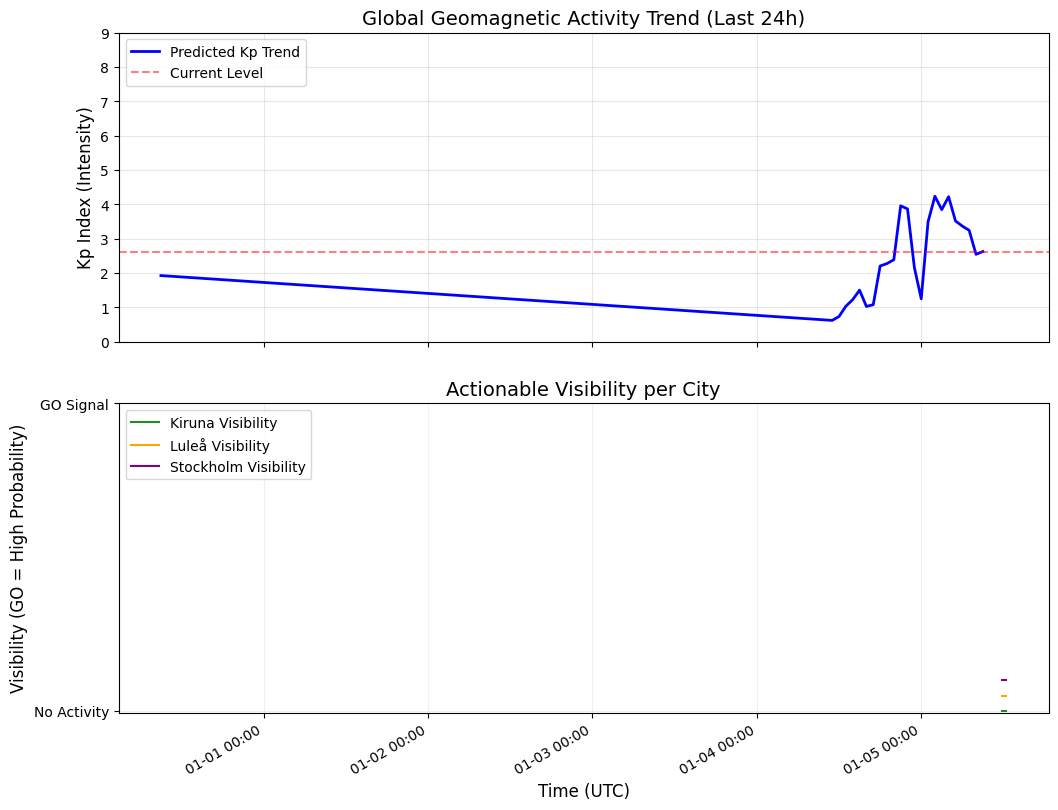

Uploading /Users/nico/Documents/GitHub/ID2223_Project/aurora_dashboard.png: 0.000%|          | 0/55708 elapsed…

KeyboardInterrupt: 

In [ ]:
# 7. VISUAL DASHBOARD GENERATION
# We pull the history of predictions to show the timeline
history_df = monitor_fg.read().sort_values(by='time')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Kp Index Trend
ax1.plot(solar_wind_df['time'], solar_wind_df['predicted_kp'], color='blue', linewidth=2, label='Predicted Kp Trend')
ax1.axhline(y=predicted_kp, color='red', linestyle='--', alpha=0.5, label='Current Level')
ax1.set_ylabel('Kp Index (Intensity)', fontsize=12)
ax1.set_ylim(0, 9)
ax1.set_title('Global Geomagnetic Activity Trend (Last 24h)', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: City Visibility Timeline (The "Go" signal)
colors = {'Kiruna': 'forestgreen', 'Luleå': 'orange', 'Stockholm': 'purple'}
for i, city in enumerate(settings.CITIES.keys()):
    city_hist = history_df[history_df['city'] == city].tail(24).copy()
    # Map "GO" to 1, others to 0 for plotting
    city_hist['go_val'] = city_hist['status'].apply(lambda x: 1 if x == "GO" else 0)
    
    # Offset the city lines slightly so they are all visible
    ax2.step(city_hist['time'], city_hist['go_val'] + (i * 0.05), label=f'{city} Visibility', color=colors[city], where='post')

ax2.set_ylabel('Visibility (GO = High Probability)', fontsize=12)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['No Activity', 'GO Signal'])
ax2.set_title('Actionable Visibility per City', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.2)

plt.xlabel('Time (UTC)', fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate()

# Save the dashboard
dashboard_path = "aurora_dashboard.png"
plt.savefig(dashboard_path, bbox_inches='tight')
print(f"\nDashboard saved as {dashboard_path}")
plt.show()

# 8. Upload to Hopsworks Resources
dataset_api = project.get_dataset_api()
if not dataset_api.exists("Resources/aurora"):
    dataset_api.mkdir("Resources/aurora")

# Upload the latest dashboard for public viewing
dataset_api.upload(dashboard_path, "Resources/aurora/latest_dashboard.png", overwrite=True)
# Upload a timestamped version for history
timestamp = current_time.strftime('%Y%m%d_%H%M')
dataset_api.upload(dashboard_path, f"Resources/aurora/history/dashboard_{timestamp}.png", overwrite=True)

print(f"Dashboard uploaded to Hopsworks: Resources/aurora/latest_dashboard.png")

# Save the dashboard into the docs folder for GitHub Pages
dashboard_path = "docs/aurora/assets/img/latest_dashboard.png"
plt.savefig(dashboard_path, bbox_inches='tight')